# Bot Scrapper

This is a bot scrapper that downloads images from google images and saves them in a folder.


In [10]:
search_string = 'infrared imaging mines'
folder_path = ".\dataSet\MineField"

<span style="color:red">Don't change the code below.</span>


In [11]:
%pip install selenium urllib3

Note: you may need to restart the kernel to use updated packages.


In [12]:
from __future__ import annotations  # noqa: F404

import os
import ssl
import time

import urllib3
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.support.ui import WebDriverWait

iter = 0

In [13]:
def create_nested_folder(folder_path: str) -> None:
    folder_path = folder_path.rstrip("/").rstrip("\\")
    folders = folder_path.split(os.sep)

    path = "."
    for folder in folders:
        path = os.path.join(path, folder)
        if not os.path.exists(path):
            os.mkdir(path)

In [14]:
def download_image(image_element) -> None:
    global iter
    global folder_path
    try:
        create_nested_folder(folder_path)

        http = urllib3.PoolManager(cert_reqs="CERT_NONE")
        response = http.request(
            "GET", image_element[0].get_attribute("src"), preload_content=False
        )
        with open(f"{folder_path}/{iter}.jpg", "wb") as out_file:
            out_file.write(response.data)
        response.release_conn()
        iter += 1
    except Exception as e:
        print(e)
        pass

In [15]:
class Driver:
    def __init__(self: Driver) -> None:
        options = webdriver.ChromeOptions()
        options.add_argument("--remote-debugging-port=8000")
        self.driver = webdriver.Chrome()  # options.add_argument("--headless")
        self.wait = WebDriverWait(self.driver, 10)
        # self.driver.maximize_window()
        self.driver.set_window_size(1920, 1080)
        self.driver.get("https://www.google.com/")

    def setup(self: Driver) -> None:
        self.cookie_validator()

    def cookie_validator(self: Driver) -> None:
        self.wait.until(
            ec.presence_of_element_located((By.CSS_SELECTOR, "#L2AGLb > div")),
        )
        Driver.driver.find_element(By.CSS_SELECTOR, "#L2AGLb > div").click()

    def search(self: Driver, search_string: str) -> None:
        self.driver.get(
            f"https://www.google.com/search?q={search_string}&tbm=isch",
        )

    def get_images(self: Driver) -> list:
        return self.driver.find_elements(
            By.XPATH,
            '//*[@id="islrg"]/div[1]/div/a[1]/div/img',
        )

In [16]:
class Item:
    def __init__(self: Item, url: str, driver: Driver) -> None:
        self.url = url
        self.Driver = driver

    def get_children(self: Item) -> list:
        return Driver.driver.find_elements(
            By.XPATH,
            '//*[@id="Sva75c"]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div/c-wiz/div/div/div/div[1]/div[3]/div/div/a[1]/div[1]/img',
        )

    def download(self, image_element: list) -> None:
        image_element[0].click()
        global folder_path
        global iter
        try:
            create_nested_folder(folder_path)

            http = urllib3.PoolManager(cert_reqs="CERT_NONE")
            response = http.request(
                "GET",
                image_element[0].get_attribute("src"),
                preload_content=False,
            )
            with open(f"{folder_path}/{iter}-fille.jpg", "wb") as out_file:
                out_file.write(response.data)
            response.release_conn()
            iter += 1
        except Exception as e:
            print(e)
            pass

        self.driver.execute_script("window.history.go(-1)")

In [17]:
Driver = Driver()
Driver.setup()
Driver.search(search_string)
images = Driver.get_images()

https://media.cnn.com/api/v1/images/stellar/prod/230814175258-npw-pkg-mines-vpx.jpg?c=original
Found 12 child images


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'media.cnn.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Found 12 child images
https://i.insider.com/64dc92c85e5d5a00195ef8ab?width=1200&format=jpeg


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'i.insider.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Found 12 child images
https://pbs.twimg.com/ext_tw_video_thumb/1691804156061679616/pu/img/Ma9l8TyLoeIcU-zg.jpg:large


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pbs.twimg.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Found 12 child images
https://sc04.alicdn.com/kf/H48988839788e41c0bd67868f2fbd10fdi/200170725/H48988839788e41c0bd67868f2fbd10fdi.jpg


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sc04.alicdn.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Found 12 child images
https://ae01.alicdn.com/kf/H4853c0ab094e4114b327871e9c289a525/Hti-Infrared-Imaging-Camera-HT-301-Industrial-PCB-Circuit-Floor-Heating-Pipe-Detection-Seek-Thermal-Imager.jpg


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ae01.alicdn.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Found 12 child images
https://i.ytimg.com/vi/MO8CWts2-P8/mqdefault.jpg
Found 12 child images


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'i.ytimg.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


https://www.businessinsider.in/thumb.cms?msid=102775367&width=1200&height=900


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.businessinsider.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Found 12 child images
https://i.ytimg.com/vi/9HLdiJAZNTM/maxresdefault.jpg


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'i.ytimg.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Found 12 child images
https://volatusaerospace.com/wp-content/uploads/2022/04/Ukraine-ISR-Drones-Thermal-1024x778.png


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'volatusaerospace.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Found 12 child images
https://external-preview.redd.it/new-demining-tactic-by-ukrainian-sappers-mines-heated-by-v0-bmJxZW9rb2Q0YmliMT64lf9Qwl9vjGdFC0KTaJzgmHx-WjXnqAa8J6MPMQFQ.png?width=640&crop=smart&format=pjpg&auto=webp&s=122fabf8157568e45d70670ae96d8e1779c942d5


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'external-preview.redd.it'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Found 12 child images
https://img.pravda.com/images/doc/c/1/c121b89-skylab-new-military-grade-drone--lightrocket-via-getty-images-.jpg


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'img.pravda.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Found 12 child images
https://media.licdn.com/dms/image/D4E12AQH0KkGtd_1ruA/article-cover_image-shrink_600_2000/0/1692789707251?e=2147483647&v=beta&t=gaGDp5bNaT0jI2HUmfnNBUkUBHhVSHJK3BxuakUPZNw


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'media.licdn.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Found 12 child images
https://www.researchgate.net/publication/331430226/figure/fig1/AS:732313369456641@1551608521473/An-instance-of-the-underground-mine-experiment-a-shows-the-thermal-camera-equipped.png


C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.researchgate.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



No host specified.
Found 12 child images
Found 12 child images
https://i.insider.com/64dc92c45e5d5a00195ef8a7?width=1136&format=jpeg

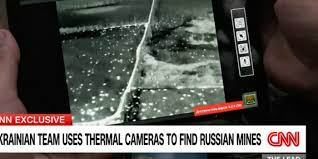

C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'i.insider.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [18]:
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE


def find_elements(xpath):
    return WebDriverWait(Driver.driver, 10).until(
        ec.presence_of_all_elements_located((By.XPATH, xpath))
    )


for index, image in enumerate(images):
    try:
        image.click()

        main_image_xpath = '//*[@id="Sva75c"]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div/div[3]/div[1]/a/img[1]'
        main_image_element = find_elements(main_image_xpath)
        print(main_image_element[0].get_attribute("src"))
        download_image(main_image_element)
        children_xpath = '//*[@id="Sva75c"]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div/c-wiz/div/div/div/div[1]/div[3]/div/div/a[1]/div[1]/img'
        children = find_elements(children_xpath)
        print(f"Found {len(children)} child images")
        time.sleep(1)

        for child_id, child in enumerate(children):
            try:
                children = find_elements(children_xpath)
                child = children[child_id]
                child.click()
                print(f"Found {len(children)} child images")
                time.sleep(1)
                child_image_xpath = '//*[@id="Sva75c"]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div/div[3]/div[1]/a/img[1]'
                child_image_element = find_elements(main_image_xpath)
                print(child_image_element[0].get_attribute("src"))
                download_image(child_image_element)
                Driver.driver.execute_script("window.history.go(-1)")
            except Exception as e:
                print(f"Error processing child image {child_id}: {e}")
    except Exception as e:
        print(f"Error processing main image {index}: {e}")